# Lecture 10A — Notebook 10A.3: Cepstral Pitch Peak Tracking (Optional Quick Win)

**Purpose:** Track pitch over time using cepstral peak location and compare to autocorrelation pitch in the same segment.

This notebook follows the **EE519 hands-on protocol** (Lectures 7–9): manifest workflow, micro-checkpoints, debugging hints, saved figures, and reflection wrap-up.


In [9]:
import os, json, math, re
from pathlib import Path

import numpy as np
import scipy.signal as sig
import scipy.fft as fft
import matplotlib.pyplot as plt

# Optional: recording in notebook
try:
    import sounddevice as sd
    HAS_SD = True
except Exception as e:
    HAS_SD = False
    print("sounddevice not available (recording disabled).", e)

# Optional: playback in notebook
try:
    from IPython.display import Audio, display
    HAS_IPY_AUDIO = True
except Exception:
    HAS_IPY_AUDIO = False

# ---------- Project paths ----------
PROJECT_ROOT = Path.cwd() / "EE519_L10A_Project"
REC_DIR = PROJECT_ROOT / "recordings"
FIG_DIR = PROJECT_ROOT / "figures"
MANIFEST_PATH = PROJECT_ROOT / "manifest.json"

for d in [REC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def load_manifest(path=MANIFEST_PATH):
    if path.exists():
        return json.loads(path.read_text())
    return {"course":"EE519","lecture":"10A","created_utc":None,"clips":[]}

def save_manifest(manifest, path=MANIFEST_PATH):
    if manifest.get("created_utc") is None:
        manifest["created_utc"] = str(np.datetime64("now"))
    path.write_text(json.dumps(manifest, indent=2))
    print("Saved manifest:", path)

manifest = load_manifest()

def save_fig(fig, name, dpi=150):
    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved figure:", out)
    return out

# ---------- WAV I/O ----------
import wave
def write_wav(path: Path, x: np.ndarray, fs: int):
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1.0, 1.0)
    x_i16 = (x * 32767.0).astype(np.int16)
    with wave.open(str(path), "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(fs)
        wf.writeframes(x_i16.tobytes())

def read_wav(path: Path):
    with wave.open(str(path), "rb") as wf:
        fs = wf.getframerate()
        n = wf.getnframes()
        x = np.frombuffer(wf.readframes(n), dtype=np.int16).astype(np.float32) / 32768.0
    return fs, x

def peak_normalize(x, target=0.98):
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * target

def play_audio(x, fs, label="audio"):
    if not HAS_IPY_AUDIO:
        print("(Audio playback not available)", label)
        return
    display(Audio(x, rate=fs))

def record_clip(seconds=2.0, fs=16000):
    if not HAS_SD:
        raise RuntimeError("sounddevice not available. Load wav files instead.")
    print(f"Recording {seconds:.1f}s @ {fs} Hz ...")
    x = sd.rec(int(seconds*fs), samplerate=fs, channels=1, dtype="float32")
    sd.wait()
    return fs, x.squeeze()

def add_clip_to_manifest(filename, label, fs, notes=""):
    clip = {
        "filename": filename,
        "label": label,
        "fs": int(fs),
        "notes": notes,
        "added_utc": str(np.datetime64("now")),
        "selections": {}
    }
    manifest["clips"].append(clip)
    save_manifest(manifest)
    return len(manifest["clips"]) - 1

def list_clips():
    for i,c in enumerate(manifest["clips"]):
        print(f"[{i}] {c['label']:12s}  {c['filename']}  fs={c['fs']}  notes={c.get('notes','')}")

# ---------- Framing helpers ----------
def frame_signal(x, N, H):
    if len(x) < N:
        x = np.pad(x, (0, N-len(x)))
    num = 1 + (len(x) - N)//H
    idx = np.arange(N)[None,:] + H*np.arange(num)[:,None]
    return x[idx]

def seconds_to_samples(t0, t1, fs, xlen):
    s0 = int(max(0, round(t0*fs)))
    s1 = int(min(xlen, round(t1*fs)))
    if s1 <= s0:
        raise ValueError("Bad selection: t1 must be > t0")
    return s0, s1

def samples_to_frame_range(s0, s1, N, H, xlen):
    f0 = max(0, int((s0 - N)//H) + 1)
    f1 = min(int((s1)//H), int((xlen-N)//H))
    if f1 < f0:
        f0 = max(0, int(s0//H))
        f1 = min(int((xlen-N)//H), f0)
    return f0, f1

def db(x):
    return 20*np.log10(np.maximum(x, 1e-12))

print("Project root:", PROJECT_ROOT)
print("Clips in manifest:", len(manifest["clips"]))


Project root: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project
Clips in manifest: 19


## 1) Choose clip + segment (ideally a voiced vowel or voiced region in a sentence)


In [10]:
list_clips()
CLIP_IDX = 0
clip = manifest["clips"][CLIP_IDX]
fs, x = read_wav(REC_DIR/clip["filename"])
x = peak_normalize(x)

print("Selected:", CLIP_IDX, clip["label"], clip["filename"], "fs=", fs)
print("Segments:", list(clip.get("selections", {}).get("analysis_segments", {}).keys()))


[0] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[1] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[2] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[3] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[4] sentence      student_sentence.wav  fs=16000  notes=short sentence
[5] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[6] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[7] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[8] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[9] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[10] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[11] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[12] sentence      student_sentence.wav  fs=16000  notes=short sentence
[13] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[14] vowel_a       student_vowel_a.wav  fs=16000  note

In [12]:
segment_name = "vowel_mid"
sel = clip["selections"]["analysis_segments"][segment_name]

N = sel["N"]; H = sel["H"]
f0, f1 = sel["frame_range"]
window = sig.windows.hann(N, sym=False)

frames = frame_signal(x, N, H)
frame_ids = np.arange(f0, f1+1)
NFFT = 2048 if fs <= 16000 else 4096

print("Frame range:", (f0, f1), "N/H:", (N, H), "frames:", len(frame_ids))


Frame range: (98, 150) N/H: (400, 160) frames: 53


## 2) Cepstral pitch estimate per frame

We search for the max cepstral peak in a plausible pitch period range:
- 2–20 ms  (≈ 50–500 Hz)

For each frame:
- compute cepstrum
- find peak in range → T0
- convert to f0 = 1/T0


In [4]:
TMIN_MS, TMAX_MS = 5.0, 20.0
quef_ms = (np.arange(NFFT)/fs)*1000.0
mask = (quef_ms >= TMIN_MS) & (quef_ms <= TMAX_MS)
mask_idx = np.where(mask)[0]

f0_cep = []
t_frame = []

for fi in frame_ids:
    fr = frames[fi] * window
    X = fft.rfft(fr, n=NFFT)
    mag = np.abs(X) + 1e-12
    logmag = np.log(mag)
    cep = fft.irfft(logmag, n=NFFT)

    idx = mask_idx[np.argmax(cep[mask_idx])]
    T0_ms = quef_ms[idx]
    f0 = 1000.0 / T0_ms
    f0_cep.append(f0)
    t_frame.append((fi*H + N/2)/fs)

f0_cep = np.array(f0_cep)
t_frame = np.array(t_frame)

print("Cepstral pitch: min/median/max =", np.min(f0_cep), np.median(f0_cep), np.max(f0_cep))


Cepstral pitch: min/median/max = 87.91208791208791 100.62893081761007 197.53086419753086


## 3) Autocorrelation pitch estimate (baseline)

We do a simple autocorrelation-based pitch per frame:
- compute autocorrelation
- search in lag range corresponding to 50–500 Hz
- pick best peak

This is intentionally simple for teaching.


In [5]:
def autocorr_pitch(frame, fs, fmin=50, fmax=500):
    frame = frame - np.mean(frame)
    ac = np.correlate(frame, frame, mode="full")[len(frame)-1:]
    ac[0] = 0.0  # ignore zero lag
    lag_min = int(fs/fmax)
    lag_max = int(fs/fmin)
    lag_max = min(lag_max, len(ac)-1)
    if lag_max <= lag_min:
        return np.nan
    lag = lag_min + np.argmax(ac[lag_min:lag_max+1])
    return fs/lag

f0_ac = []
for fi in frame_ids:
    fr = frames[fi] * window
    f0_ac.append(autocorr_pitch(fr, fs))
f0_ac = np.array(f0_ac)

print("AC pitch: min/median/max =", np.nanmin(f0_ac), np.nanmedian(f0_ac), np.nanmax(f0_ac))


AC pitch: min/median/max = 87.91208791208791 90.3954802259887 380.95238095238096


## 4) Plot and compare pitch tracks


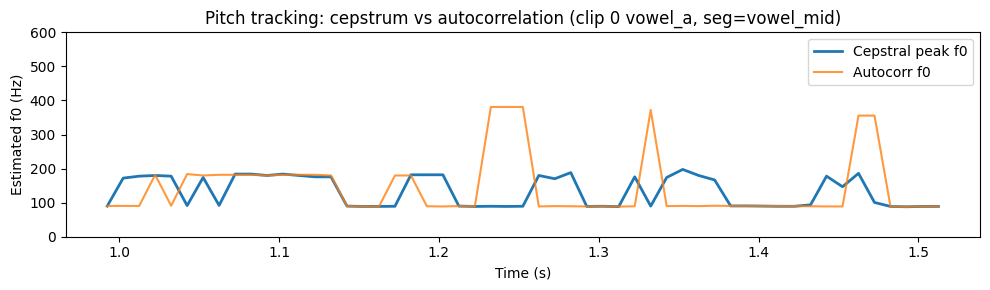

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\pitch_tracks_clip0_vowel_mid.png


WindowsPath('c:/Users/K/Documents/usc/ee519/ee519-lecture/lecture9/EE519_L10A_Project/figures/pitch_tracks_clip0_vowel_mid.png')

In [6]:
fig = plt.figure(figsize=(10,3))
plt.plot(t_frame, f0_cep, label="Cepstral peak f0", linewidth=2.0)
plt.plot(t_frame, f0_ac, label="Autocorr f0", linewidth=1.5, alpha=0.8)
plt.title(f"Pitch tracking: cepstrum vs autocorrelation (clip {CLIP_IDX} {clip['label']}, seg={segment_name})")
plt.xlabel("Time (s)"); plt.ylabel("Estimated f0 (Hz)")
plt.ylim([0, 600])
plt.legend()
plt.tight_layout(); plt.show()

save_fig(fig, f"pitch_tracks_clip{CLIP_IDX}_{re.sub(r'[^a-zA-Z0-9_]+','_',segment_name)}.png")


## 5) Debugging guidance (very common)

If cepstral pitch is unstable:
- you may be on unvoiced frames (sentence contains both voiced/unvoiced)
- selection includes onsets/offsets
- try a steadier vowel region
- consider a slightly longer window (e.g., 30 ms) for pitch estimation

If autocorrelation pitch “octaves”:
- typical ACF error: choosing 2× or ½ lag
- try restricting fmin/fmax


## Wrap-up
**What you learned:** cepstrum can provide a simple pitch estimate using a quefrency-domain peak, and you can cross-check against autocorrelation.  


## Reflection questions
1. On your vowel segment, how close are cepstral pitch and autocorrelation pitch?  
2. On a sentence segment, where do they disagree most, and why (voiced/unvoiced)?  
3. What window length gave you the most stable pitch track?  
4. If you had to choose one method for noisy speech, which would you trust more and why?


### Answers

1. They were reasonably close but the autocorrelation pitch had a few extra peaks.
2. It was hard to tell since I had to tab out and go back to the waveform. However, I believe the voiced and unvoiced differed the most because the pitch. This difference between voice and unvoiced speech could cause the autocorrelation errors.
3. 20 ms seemed to be enough. If it was too short the cycles wouldn't be enough for accurate estimation.
4. Cepstral pitch estimation better at dealing with noise because it separates the spectral envelope and extra noise.